# Lab 9

In [638]:
from numpy import fft
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
from PIL import Image, ImageOps

## ANALIZA OBRAZÓW

In [639]:
def image_change(path, invert=True):
    img = Image.open(path) 
    gray = img.convert('L')
    if invert:
        gray = ImageOps.invert(gray)
    transformed = np.swapaxes(np.array(gray), 0, 1)
    return img, transformed

def plot_fig(img, title, size=(5,5)):
    # plt.figure(figsize=size)
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.show()


def detect_match(img_path, pattern_path, prob=0.95, invert=True, all=True):
    #Wczytanie i dokonanie odwrócenia kolorów
    img, img_transformed = image_change(img_path, invert)
    pat, pat_transformed = image_change(pattern_path, invert)

    #Transformacja
    img_fft = np.fft.fft2(img_transformed)
    img_fft_shift_abs = np.abs(img_fft)

    #Wykresy
    if all:
        plot_fig(np.swapaxes(np.log(img_fft_shift_abs),0,1), 'Moduł')
        plot_fig(np.swapaxes(np.angle(img_fft),0,1), 'Faza')
    plot_fig(np.swapaxes(pat_transformed,0,1), 'Wzór')
    plot_fig(np.swapaxes(img_transformed,0,1),'Obraz')

    C = np.real(np.fft.ifft2(np.multiply(img_fft, np.fft.fft2(np.rot90(pat_transformed, 2), s=img.size))))

    C_min = np.max(C) * prob
    args = np.argwhere(C >= C_min)  

    for x,y in args:
        for w in [0, pat.size[0]-1]:
            for z in range(pat.size[1]):
                img.putpixel((x-w, y-z), (255,0,0))
        for h in [0, pat.size[1]-1]:
            for z in range(pat.size[0]):
                img.putpixel((x-z, y-h), (255,0,0))

    plot_fig(img, 'Znalezione powtórzenia', size=(10,10) )


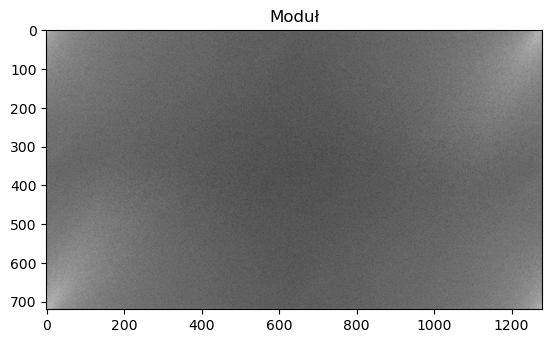

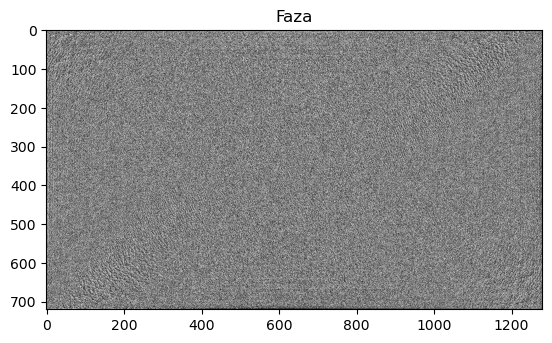

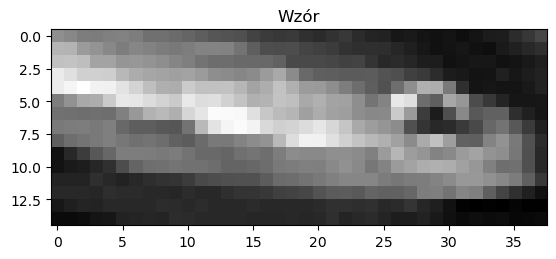

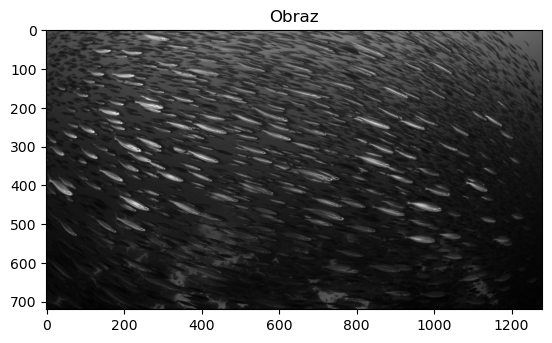

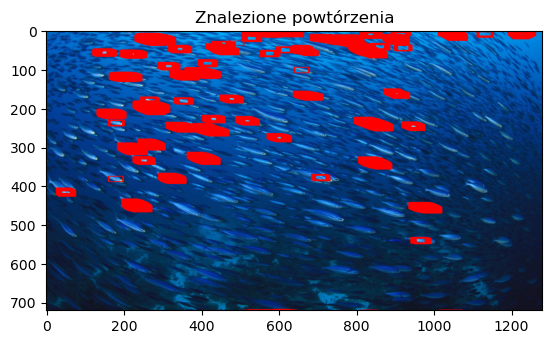

In [640]:
detect_match("school.jpg", "fish1.png", prob =0.65, invert=False)

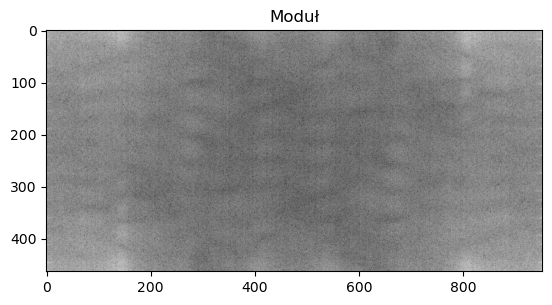

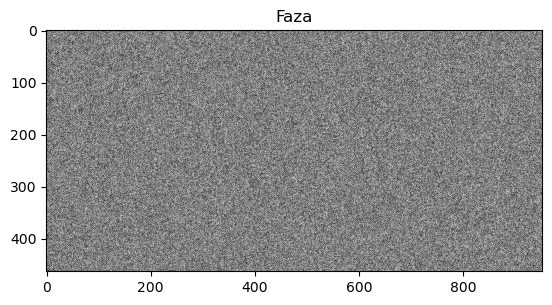

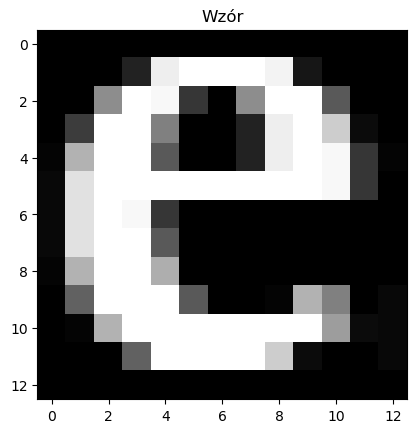

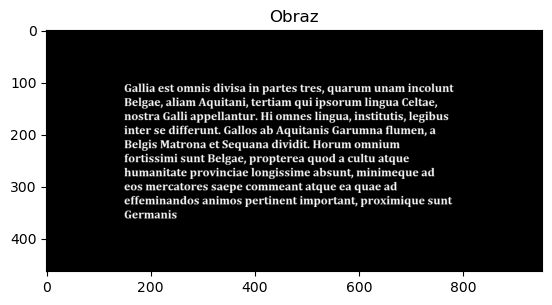

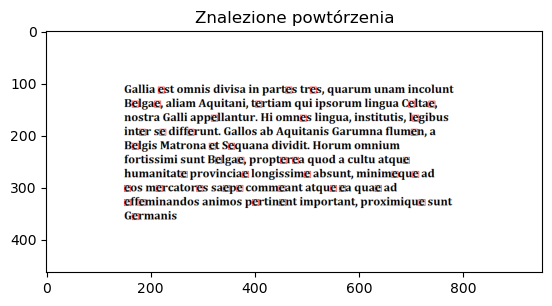

In [641]:
detect_match("galia.png", "galia_e.png")

## OCR

In [642]:
from PIL import Image, ImageDraw, ImageFont
import os
import pandas as pd
import cv2
import random
import numpy as np

In [643]:
def create_alphabet_images(font_file_path, output_folder, font_size=30):
    alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
    extra = ".,?!"
    font = ImageFont.truetype(font_file_path, font_size)

    for letter in alphabet+extra:
        letter = letter.lower()
        image = Image.new("RGB", (font_size,int(font_size*3)), color="white")
        draw = ImageDraw.Draw(image)
        draw.text((0, 0), letter, font=font, fill="black")

        if letter in ["m", "w"]:
            a = 2
        elif letter in ["i", "j", "!", ".", ",", "l", "f", "r"]:
            a=19
        else:
            a=11

        image_with_whitespace = Image.new("RGB", (font_size-a, font_size+7), color="white")
        image_with_whitespace.paste(image, (1, 0))

        if letter in extra:
            image_with_whitespace.save(f"{output_folder}/e{extra.index(letter)}.png")
        else:
            image_with_whitespace.save(f"{output_folder}/{letter}.png")

In [644]:
def create_text_images(text,font_file_path, output_folder, font_size=30, wide=20):
    text = text.lower() 

    font = ImageFont.truetype(font_file_path, font_size)

    image = Image.new("RGB", (font_size*50,int(font_size*3)*wide), color="white")
    draw = ImageDraw.Draw(image)
    draw.text((10, 10), text, font=font, fill="black", spacing=50)

    image_with_whitespace = Image.new("RGB", (font_size*50, font_size*wide), color="white")
    image_with_whitespace.paste(image, (1, 1))

    image_with_whitespace.save(f"{output_folder}.png")

def rotate_text_image_randomly(image_path, output_path, angle=10):
    image = Image.open(image_path)
    # angle = random.uniform(-25, 25)
    rotated_image = image.rotate(angle, expand=True, fillcolor='white')
    rotated_image.save(output_path)

In [645]:
# create_alphabet_images("./fonts/Lato-Black.ttf", "./letters/lato")
# create_alphabet_images("./fonts/Alice-Regular.ttf", "./letters/alice")

In [646]:
O = "okljphdimneabhucqgrsft0yvw1xz89234567.,!?"

def create_list_order(Ord, font):
    new = []
    extra = ".,?!"
    for ch in Ord:
        if ch in extra:
            new.append(f"./letters/{font}/e{extra.index(ch)}.png")
        else:
            new.append(f"./letters/{font}/{ch.upper()}.png")
    return new

ORDER_LATO = create_list_order(O, "lato")
ORDER_ALICE = create_list_order(O, "alice")

In [647]:
# Usuwamie szumu z obrazu poczatkowego
def svd_f(image,k=20):
    U, S, Vt = np.linalg.svd(image, full_matrices=False)
    S = np.diag(S[:k])
    U = U[:, :k]
    Vt = Vt[:k, :]
    denoised_image = np.dot(U, np.dot(S, Vt))
    return np.clip(denoised_image, 0, 255).astype(np.uint8)

#Prostowanie obrazu wejsciowego
def get_angle(img_to_rotate):
    newImage = img_to_rotate.copy()
    gray = cv2.cvtColor(newImage, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9, 9), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
    dilate = cv2.dilate(thresh, kernel, iterations=5)
    contours, hierarchy = cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)
    largestContour = contours[0]
    minAreaRect = cv2.minAreaRect(largestContour)
    angle = minAreaRect[-1]
    return -1.0 * angle

def rotate(img_to_rotate, angle: float):
    newImage = img_to_rotate.copy()
    (h, w) = newImage.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    newImage = cv2.warpAffine(newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return newImage

def img_to_straight(path):
    cvImage = cv2.imread(path)
    angle = get_angle(cvImage)
    img = rotate(cvImage, -1.0 * angle)
    cv2.imwrite(path,img)


#Wczytywanie obrazow

def image_change(path, invert=True, rotate=True, svd_b=(False,0)):
    if rotate:
        img_to_straight(path)
    img = Image.open(path)
    if svd_b[0]:
        img_np = np.array(img.convert('L'))
        img = Image.fromarray(svd_f(img_np,svd_b[1]))
    gray = img.convert('L')
    if invert:
        gray = ImageOps.invert(gray)
    transformed = np.swapaxes(np.array(gray), 0, 1)
    return img, transformed

In [706]:
# Funkcja wykrywajaca pokrycia wyszukanych wzorcow - patrzymy czy srodek wspolrzednej miejsca z znalezionych wzorcem,
# znajduje sie w slowniku miejsc zajetych (miejsce zajete - wspolrzedne na ktorych juz znaleziono wzorzec)
def overlapping(x,y,pat,s):
    w=pat.size[0]//2
    h = pat.size[1]//2
    if (x-w, y-h) in s:
            return False
    return True


def match(img, img_transformed, pattern_path,set_k, prob=0.999, dic={}, svd=False, prob_e=1):
    if pattern_path.split("/")[-1] in ["H.png"]:
        prob=1
    if pattern_path.split("/")[-1] in ["e0.png", "H.png", "e3.png", "e2.png", "e1.png"]:
        prob = prob_e
    if pattern_path.split("/")[-1] in ["I.png", "C.png"]:
        prob = 0.93
    if pattern_path.split("/")[-1] in ["L.png", "N.png"]:
        prob = 0.99

    pat, pat_transformed = image_change(pattern_path, rotate=False)
    img_fft = np.fft.fft2(img_transformed)
    img_fft_shift_abs = np.abs(img_fft)
    C = np.real(np.fft.ifft2(np.multiply(img_fft, np.fft.fft2(np.rot90(pat_transformed, 2), s=img.size))))
    C_min = np.max(C) * prob
    args = np.argwhere(C >= C_min)

    extra = ".,?!"
    count = 0
        
    for x,y in args:
        if overlapping(x,y,pat,set_k):
            count += 1
            name = pattern_path.split("/")[-1].split(".")[0]
            new_cor = (x-pat.size[0]+1, y-pat.size[1]+1)
            if len(name) > 1:
                dic[(x,y)] = (extra[int(name[-1])].lower(), new_cor)
            else:
                dic[(x,y)] = (name.lower(), new_cor)
            for w in range(pat.size[0]):
                for h in range(pat.size[1]):
                    set_k.add((x-w, y-h))


    return dic, img, set_k, count


#Wykrywa znaki nowej lini i spacji - patrzymy na odkleglosci miedzy wspolrzednymi wykrytych najblizej znakow
def white_spaces(t1, s1,s2,dic,space_len=3, new_line=25):
    if dic[s1][0] in ".,?!":
        return ""
    r1 = t1[0] - s2[0]
    r2 = s1[0] - s2[0]
    if r1 > space_len:
        return " "
    elif r2 < - new_line:
        return "\n"
    return ""

    

def read_text(text_path,ORDER, svd_bool=(False,0), r=False,prob=0.999, prob_e=1):
    char_count = {}
    dic = {}
    set_ = set()
    img, img_transformed = image_change(f"./text/{text_path}.png", svd_b=svd_bool, rotate=r)
    for plik in ORDER:
        dic, img, set_, c = match(img, img_transformed,plik,set_k=set_, dic=dic,prob=prob, prob_e=prob_e)
        char_count[plik.split("/")[-1]]=c
    keys = sorted(dic.keys(), key=lambda x: (x[1],x[0]))
    string = ""
    for key_id in range(len(keys)):
        if key_id != 0:
            string = string + white_spaces(dic[keys[key_id]][1],keys[key_id], keys[key_id-1],dic)
        string += dic[keys[key_id]][0]
    plot_fig(img, title="Tekst")

    return string, char_count


#Słownik z wszystkimi znakami z text
def create_dic(text):
    dic={}
    for char in text:
        if dic.get(char) == None:
            dic[char] = 1
        else:
            dic[char] += 1
    return dic

#Funkcja wypisujaca dokładnośc ( patrzy tylko na wystapienia znakow, nie na kolejsnosc)
def check(wanted, got):
    all = max(len(wanted), len(got))
    sum = 0
    dic_wanted = create_dic(wanted)
    dic_got = create_dic(got)
    for key in dic_wanted.keys():
        g = dic_got.get(key)
        w = dic_wanted.get(key)
        if g is not None:
            sum += min(w,g)
    return sum/all * 100

#Genrowanie obrazu z danym tekstem, obracanie go, a nastepnie testowanie na nim programu
def create_and_check_with_rotation(text,font='Lato-Black', order=ORDER_LATO, svd_b=(False,0),rotate=True, angle=-10,prob=0.999):
    create_text_images(text,f"./fonts/{font}.ttf", f"./text/{text[0:5]}")
    if rotate:
        rotate_text_image_randomly(f"./text/{text[0:5]}.png", f"./text/{text[0:5]}.png", angle=angle)
    img_roatted = Image.open(f"./text/{text[0:5]}.png")
    plot_fig(img_roatted, title="Przed")
    string, char_count = read_text(f"{text[0:5]}", order, svd_b, r=True,prob=prob)
    text = text.lower()
    print(f"Chcemy:\n{text}\n\nDostajemy:\n{string}\n")
    checked = check(text, string)
    return f"Poprawność: {round(checked,2)}%", checked


#Genrowanie obrazu z danym tekstem,  a nastepnie testowanie na nim programu
def create_and_check(text,font='Lato-Black', order=ORDER_LATO, svd_b=(False,0),prob=0.999, prob_e=1):
    create_text_images(text,f"./fonts/{font}.ttf", f"./text/{text[0:5]}")
    string, char_count = read_text(f"{text[0:5]}", order, svd_b,prob=prob, prob_e=prob_e)
    text = text.lower()
    print(f"Chcemy:\n{text}\n\nDostajemy:\n{string}\n")
    checked = check(text, string)
    return f"Poprawność: {round(checked,2)}%", checked


## Czcionka bezszeryfowa - Lato-Black

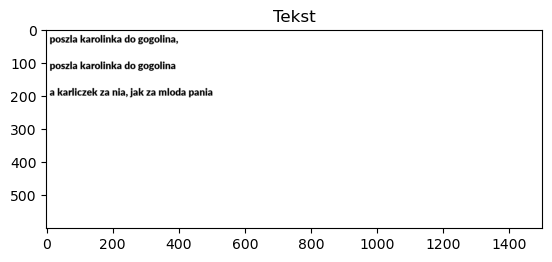

Chcemy:
poszla karolinka do gogolina,
poszla karolinka do gogolina
a karliczek za nia, jak za mloda pania

Dostajemy:
poszla karolinka do gogolina
poszla karolinka do gogolina
a karliczek za nia jak za mloda pania

Poprawność: 97.94%


In [649]:
string, check_1 = create_and_check("Poszla karolinka do gogolina,\nposzla karolinka do gogolina\na Karliczek za nia, jak za mloda pania")
print(string)

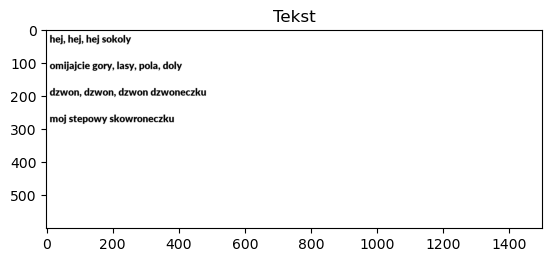

Chcemy:
hej, hej, hej sokoly
omijajcie gory, lasy, pola, doly
dzwon, dzwon, dzwon dzwoneczku
moj stepowy skowroneczku

Dostajemy:
l ej l ej l ej sokoly
omijajcie gory lasy pola doly
dzwon dzwon dzwon dzwoneczku
moj stepowy skowroneczku

Poprawność: 90.83%


In [650]:
string, check_2 =create_and_check("hej, hej, hej sokoly\nomijajcie gory, lasy, pola, doly\ndzwon, dzwon, dzwon dzwoneczku\nmoj stepowy skowroneczku")
print(string)

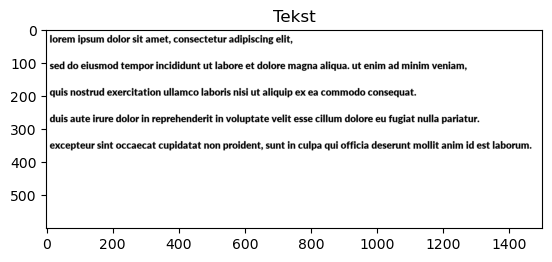

Chcemy:
lorem ipsum dolor sit amet, consectetur adipiscing elit,
sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. ut enim ad minim veniam,
quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat.
duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur.
excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

Dostajemy:
lorem ipsum dolor sitamet consectetur adipiscing elit
sed do eiusmod tempor incididuntutlal ore etdolore magna ali ua utenim ad minim yeniam
i
uisnostrud exercitation ullamco lal orisnisi utali uip ex ea commodo conse uat
i i i
duisaute irure dolor in reprel endk ritin yoluptate yelitesse cillum dolore eu fugiatnulla pariatur
excepteur sintoccaecatcupidatatnon proidk nt suntin culpa ui officia dk seruntmollitanim id estlal orum
i

Poprawność: 93.26%


In [651]:
string, check_3 = create_and_check("Lorem ipsum dolor sit amet, consectetur adipiscing elit,\nsed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam,\nquis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat.\nDuis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur.\nExcepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.")
print(string)

## Czcionka bezszeryfowa - Lato-Black z usuwaniem szumu

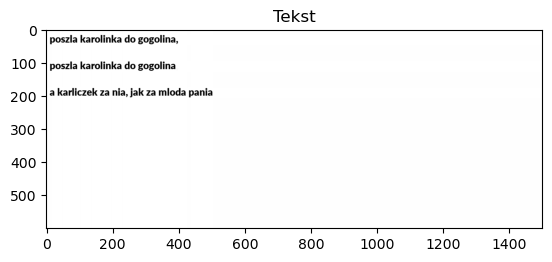

Chcemy:
poszla karolinka do gogolina,
poszla karolinka do gogolina
a karliczek za nia, jak za mloda pania

Dostajemy:
poszla karolinka do gogolina
poszla karolinka do o olina
7 7
a karliczek za nia jak za mloda pania

Poprawność: 94.9%


In [670]:
string, check_7 = create_and_check("Poszla karolinka do gogolina,\nposzla karolinka do gogolina\na Karliczek za nia, jak za mloda pania", svd_b=(True,49))
print(string)

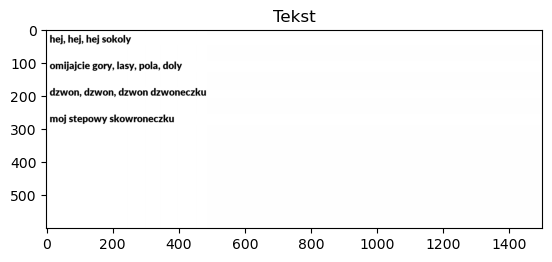

Chcemy:
hej, hej, hej sokoly
omijajcie gory, lasy, pola, doly
dzwon, dzwon, dzwon dzwoneczku
moj stepowy skowroneczku

Dostajemy:
l ej l ej l ej sokoly
omijajcie gory lasy pola doly
dzwon dzwon dzwon dzwoneczku
moj stepowy skowroneczku

Poprawność: 90.83%


In [676]:
string, check_8 = create_and_check("hej, hej, hej sokoly\nomijajcie gory, lasy, pola, doly\ndzwon, dzwon, dzwon dzwoneczku\nmoj stepowy skowroneczku", svd_b=(True,99))
print(string)

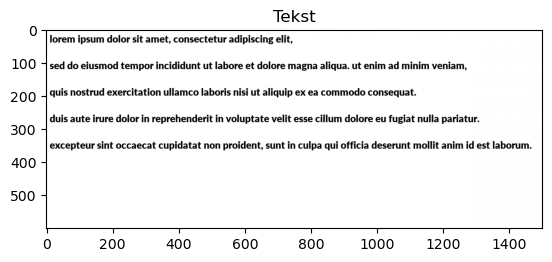

Chcemy:
lorem ipsum dolor sit amet, consectetur adipiscing elit,
sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. ut enim ad minim veniam,
quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat.
duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur.
excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

Dostajemy:
lorem ipsum dolor sitamet consectetur adipiscing elit
sed do eiusmod tempor incididuntutlal ore etdolore magna ali ua utenim ad minim yeniam
i
uisnostrud exercitation ullamco lal orisni i utali uip ex ea commcdk conse uat
i i i
duisaute irure dolor in reprel endk ritin yoluptate yelitesse cillum dolore eu fugiatnulla pariatur
excepteur sintoccaecatcupidatatnon prcident untin culpa ui officia deseruntmollitanim id estlal orum
i

Poprawność: 92.36%


In [677]:
string, check_9 = create_and_check("Lorem ipsum dolor sit amet, consectetur adipiscing elit,\nsed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam,\nquis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat.\nDuis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur.\nExcepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.", svd_b=(True,150))
print(string)

## Czcionka szeryfowa - Alice-Regular

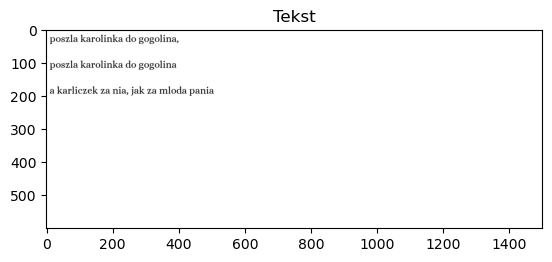

Chcemy:
poszla karolinka do gogolina,
poszla karolinka do gogolina
a karliczek za nia, jak za mloda pania

Dostajemy:
poszla karolinka do gogolina
poszla karolinka do gogolina
a karliczek za nia jak za mloda pania

Poprawność: 97.94%


In [655]:
string, check_4 = create_and_check("poszla karolinka do gogolina,\nposzla karolinka do gogolina\na Karliczek za nia, jak za mloda pania", font = 'Alice-Regular', order=ORDER_ALICE)
print(string)

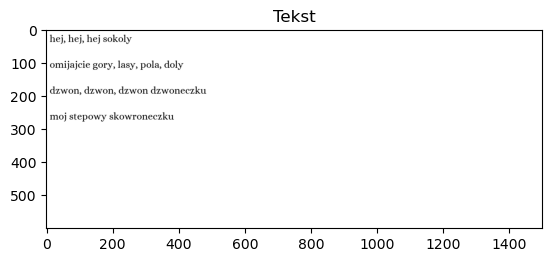

Chcemy:
hej, hej, hej sokoly
omijajcie gory, lasy, pola, doly
dzwon, dzwon, dzwon dzwoneczku
moj stepowy skowroneczku

Dostajemy:
l ej l ej l ej sokoly
omijajcie gory lasy pola doly
dzwon dzwon dzwon dzwoneczku
moj stepowy skowroneczku

Poprawność: 90.83%


In [656]:
string, check_5 = create_and_check("hej, hej, hej sokoly\nomijajcie gory, lasy, pola, doly\ndzwon, dzwon, dzwon dzwoneczku\nmoj stepowy skowroneczku", font = 'Alice-Regular', order=ORDER_ALICE)
print(string)

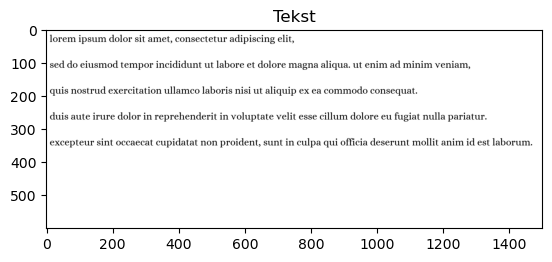

Chcemy:
lorem ipsum dolor sit amet, consectetur adipiscing elit,
sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. ut enim ad minim veniam,
quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat.
duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur.
excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

Dostajemy:
lorem ipsum dolor sitamet consectetur adipiscing elit
sed do eiusmod tempor incididuntutlabore etdolore magna alicua utenim ad minim yeniam
cuisnostrud exercitation ullamco laborisnisi utalicuip ex ea commodo consecuat
duisaute irure dolor in reprel en k ritin yoluptate yelitesse cillum dolore eu fugiatnulla pariatur
excepteur sintoccaecatcupidatatnon proi k nt suntin culpa cui officia k seruntmollitanim id estlaborum

Poprawność: 91.91%


In [657]:
string, check_6 = create_and_check("Lorem ipsum dolor sit amet, consectetur adipiscing elit,\nsed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam,\nquis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat.\nDuis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur.\nExcepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.",font = 'Alice-Regular', order=ORDER_ALICE)
print(string)

## Bezszeryfowa (patrzymy na znaki specjalne bardziej niz litery/cyferki)

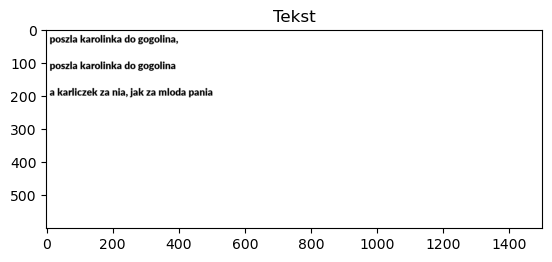

Chcemy:
poszla karolinka do gogolina,
poszla karolinka do gogolina
a karliczek za nia, jak za mloda pania

Dostajemy:
,,
poszla karolh ka do gogolh a,,
poszla karolh ka do gogolh a
a karliczek za nia jak za mloda pania

Poprawność: 89.0%


In [707]:
string, check_15 = create_and_check("Poszla karolinka do gogolina,\nposzla karolinka do gogolina\na Karliczek za nia, jak za mloda pania", prob_e=0.95)
print(string)

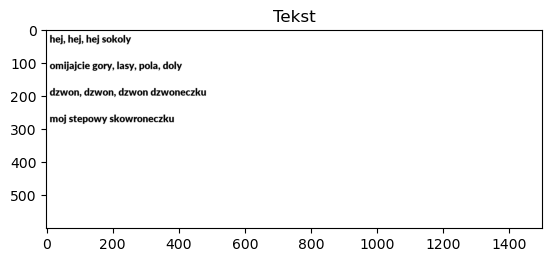

Chcemy:
hej, hej, hej sokoly
omijajcie gory, lasy, pola, doly
dzwon, dzwon, dzwon dzwoneczku
moj stepowy skowroneczku

Dostajemy:
,,,
l ej l ej l ej sokoly
omijajcie gory lasy pola doly
dzwon dzwon dzwon dzwoneczku
moj stepowy skowroneczku

Poprawność: 93.58%


In [708]:
string, check_16 = create_and_check("hej, hej, hej sokoly\nomijajcie gory, lasy, pola, doly\ndzwon, dzwon, dzwon dzwoneczku\nmoj stepowy skowroneczku", prob_e=0.95)
print(string)

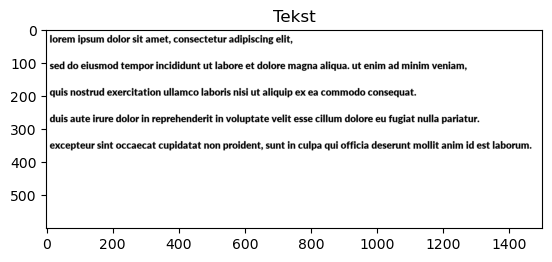

Chcemy:
lorem ipsum dolor sit amet, consectetur adipiscing elit,
sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. ut enim ad minim veniam,
quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat.
duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur.
excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

Dostajemy:
lorem ipsum dolor sitamet consectetur adipiscing elit,,
sed do eiusmod tempor incididuntutlal ore etdolore magna ali ua utenim ad minim yeniam
i,,,,
uisnostrud exercitation ullamco lal orisnisi utali uip ex ea commodo conse uat
i i i,
duisaute irure dolor in reprel endk ritin yoluptate yelitesse cillum dolore eu fugiatnulla pariatur,,
excepteur sintoccaecatcupidatatnon proidk nt suntin culpa ui officia dk seruntmollitanim id estlal orum
i

Poprawność: 94.16%


In [709]:
string, check_17 = create_and_check("Lorem ipsum dolor sit amet, consectetur adipiscing elit,\nsed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam,\nquis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat.\nDuis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur.\nExcepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.", prob_e=0.95)
print(string)

# Porównanie

In [678]:
dataset = pd.DataFrame()
dataset["Bezszeryfowa"] = [check_1, check_2, check_3]
dataset["Szeryfowa"] = [check_4, check_5, check_6]
dataset["Bezszeryfowa z usuwaniem szumu"] = [check_7,check_8, check_9]
dataset["Bezszeryfowa skupiamy sie na znakach specjalnych"] = [check_15,check_16, check_17]
dataset.index = ["Karolinka", "Sokoły", "Lorem ipsum"]
print(dataset)

             Bezszeryfowa  Szeryfowa  Bezszeryfowa z usuwaniem szumu
Karolinka       97.938144  97.938144                       94.897959
Sokoły          90.825688  90.825688                       90.825688
Lorem ipsum     93.258427  91.910112                       92.359551


# Obrócony tekst

## Bezszeryfowa bez usuwania szumu

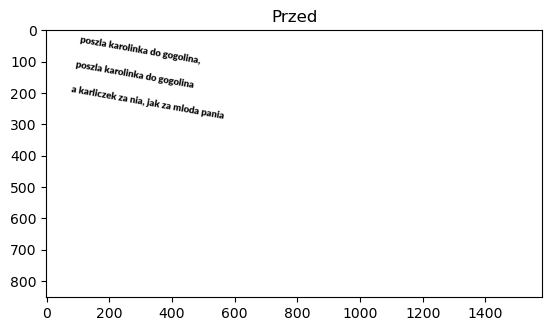

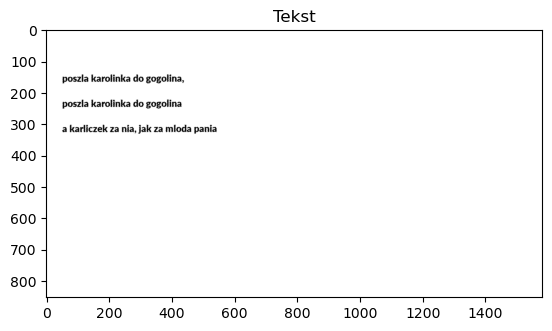

Chcemy:
poszla karolinka do gogolina,
poszla karolinka do gogolina
a karliczek za nia, jak za mloda pania

Dostajemy:
i k r k oo gogoi a
oosz a a ohw a ii
k r k oo go o i a
ooszla a oiin a g
k i k i jak za miooa o mia
a arl cze za n a

Poprawność: 67.24%


In [684]:
string, check_10 = create_and_check_with_rotation("poszla karolinka do gogolina,\nposzla karolinka do gogolina\na Karliczek za nia, jak za mloda pania", prob=0.95)
print(string)

## Bezszeryfowa z usuwania szumu

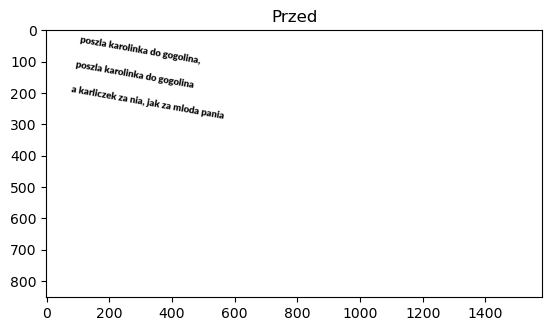

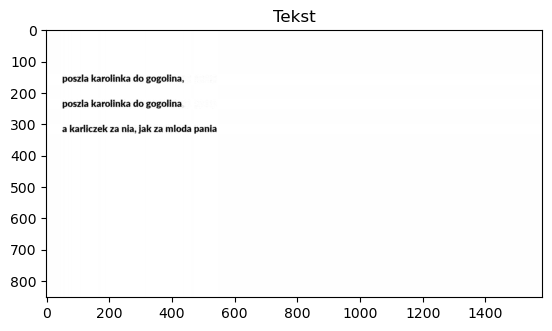

Chcemy:
poszla karolinka do gogolina,
poszla karolinka do gogolina
a karliczek za nia, jak za mloda pania

Dostajemy:
i r ka o gog i a
oosz a ka ohw o o i
k roi k oo go oi a
ooszia a wn a g b
k i k a jak za miooa o m a
a ar icze za ni

Poprawność: 65.52%


In [687]:
string, check_11 = create_and_check_with_rotation("poszla karolinka do gogolina,\nposzla karolinka do gogolina\na Karliczek za nia, jak za mloda pania", svd_b=(True,25), prob=0.95)
print(string)

## Szeryfowa bez usuwania szumu

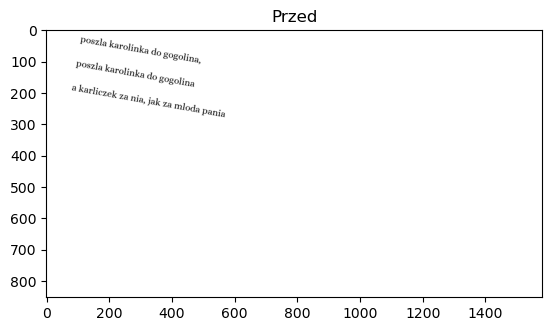

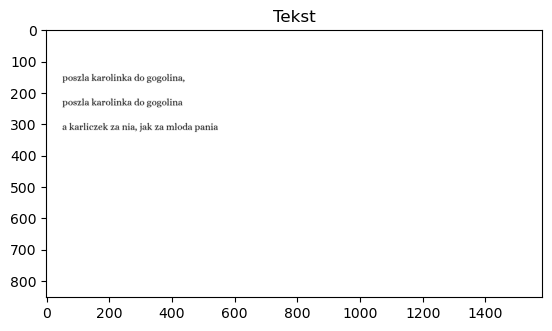

Chcemy:
poszla karolinka do gogolina,
poszla karolinka do gogolina
a karliczek za nia, jak za mloda pania

Dostajemy:
oosz a karoiimka oo gogoiima
oosz a karolimka oo gogolima
a kar iczek za uia jak za m1ooa oamia

Poprawność: 79.38%


In [688]:
string, check_12 = create_and_check_with_rotation("poszla karolinka do gogolina,\nposzla karolinka do gogolina\na Karliczek za nia, jak za mloda pania", font = 'Alice-Regular', order=ORDER_ALICE,prob=0.95)
print(string)

## Szeryfowa z usuwaniem szumu

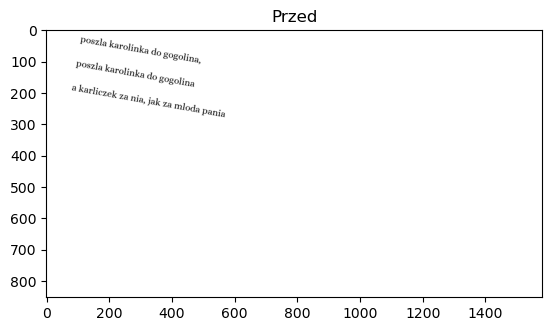

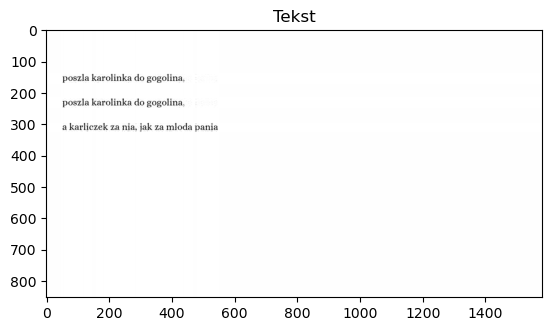

Chcemy:
poszla karolinka do gogolina,
poszla karolinka do gogolina
a karliczek za nia, jak za mloda pania

Dostajemy:
i
oosz a karolimka oo gogolima
ooszla karolimka oo gogolima
i j i
a kar iczek za mia ak za m ooa oamia

Poprawność: 78.43%


In [689]:
string, check_13 = create_and_check_with_rotation("poszla karolinka do gogolina,\nposzla karolinka do gogolina\na Karliczek za nia, jak za mloda pania", svd_b=(True,20),font = 'Alice-Regular', order=ORDER_ALICE,prob=0.95)
print(string)

# Porównanie

In [690]:
dataset = pd.DataFrame()
dataset["Bezszeryfowa"] = [check_10, check_11]
dataset["Szeryfowa"] = [check_12,check_13]
dataset.index = ["Szum", "Bez szumu"]
print(dataset)

           Bezszeryfowa  Szeryfowa
Szum          67.241379  79.381443
Bez szumu     65.517241  78.431373


# Wnioski
Wszystkie testy zostały wykonane na obrazach wygenerowanych za pomocą biblioteki ImageDraw, co moze powodować wysoką skuteczność algorytmu w sytuacjach gdy nie obrócimy wygenrowanego obrazu. Obrazy tak wygenrowane nie maja tez zakłamań, więc usuwanie szumu nie przynosi lepszych efektów.

Najgorsze efekty widzimy przy znakach specjalnych, które dla algorytmu są bardzo ciękie do prawidłowego wykrycia. Nawet przy próbie skupienia się bardziej na znakach specjalnych niz zwyklych, algorytm mimo znalezienia niektorych znakow poprawnie, najczesciej znajdywał ich za duzo, nie mowiac o tym ze nie jest w stanie rozroznic kropki od przecinka.

Jeśli chodzi o obracanie obrazu wejsciowego, uzyłam algorytmu "Deskewing", który w miare dokładnie był w stanie obrócić nasz tekst. Niestety obrazy, którym poprawilismy kąt obrócenia, miały więcej nieścisłości i nie były tak precyzyjne jak obrazy pierwotnie stworzone przez ImageDraw, a to spowodowało obizona skutecznosc programu. 

Program wymaga kilku poprawek. Na pewno mozna by było zmienic kolejność wyszukiwania znakow. Nastepnie do poprawy jest tez algorytm znajdujacy kolejnosc literek, a takze algorytm wyszukiwania znakow bialych.